# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

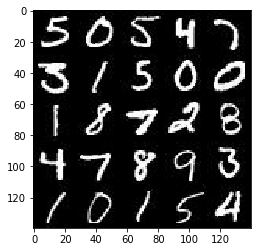

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

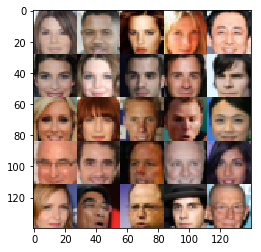

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x(1/3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.02
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(generator_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    steps = 0
    print_every=10
    show_every=100
    n_images = 25
    
    # Train    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 13.0782
Epoch 1/2... Discriminator Loss: 3.6709... Generator Loss: 0.0315
Epoch 1/2... Discriminator Loss: 0.2874... Generator Loss: 8.4575
Epoch 1/2... Discriminator Loss: 0.0732... Generator Loss: 10.5440
Epoch 1/2... Discriminator Loss: 0.0281... Generator Loss: 4.0217
Epoch 1/2... Discriminator Loss: 5.7294... Generator Loss: 16.0327
Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 6.4270
Epoch 1/2... Discriminator Loss: 0.2519... Generator Loss: 7.7577
Epoch 1/2... Discriminator Loss: 0.5697... Generator Loss: 1.4666
Epoch 1/2... Discriminator Loss: 2.9924... Generator Loss: 3.9055


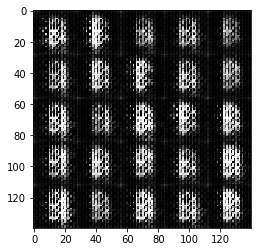

Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 1.6988
Epoch 1/2... Discriminator Loss: 3.2693... Generator Loss: 0.2046
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 2.2241
Epoch 1/2... Discriminator Loss: 0.2710... Generator Loss: 2.4078
Epoch 1/2... Discriminator Loss: 0.2322... Generator Loss: 2.4680
Epoch 1/2... Discriminator Loss: 0.3065... Generator Loss: 2.0934
Epoch 1/2... Discriminator Loss: 0.1740... Generator Loss: 2.5386
Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 2.4234
Epoch 1/2... Discriminator Loss: 0.2308... Generator Loss: 2.1956
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 1.1684


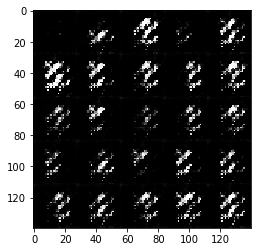

Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 2.4236
Epoch 1/2... Discriminator Loss: 0.3218... Generator Loss: 3.9577
Epoch 1/2... Discriminator Loss: 0.0505... Generator Loss: 6.0685
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 5.0000
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 0.3302... Generator Loss: 2.8033
Epoch 1/2... Discriminator Loss: 0.2927... Generator Loss: 3.2066
Epoch 1/2... Discriminator Loss: 0.2488... Generator Loss: 2.4662
Epoch 1/2... Discriminator Loss: 0.1248... Generator Loss: 3.6885
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 1.6486


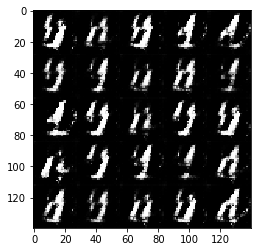

Epoch 1/2... Discriminator Loss: 0.1350... Generator Loss: 3.2043
Epoch 1/2... Discriminator Loss: 0.0725... Generator Loss: 4.8447
Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 4.2869
Epoch 1/2... Discriminator Loss: 0.4542... Generator Loss: 2.0377
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 2.4931
Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 1.6193
Epoch 1/2... Discriminator Loss: 0.2761... Generator Loss: 2.4849
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 2.6766
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.2479


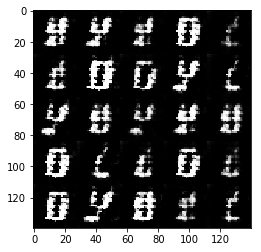

Epoch 1/2... Discriminator Loss: 0.3575... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 1.6691... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 1.8002
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 1.7735
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 7.5451
Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 4.8404
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 4.0076
Epoch 1/2... Discriminator Loss: 0.2956... Generator Loss: 2.2597
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.7017


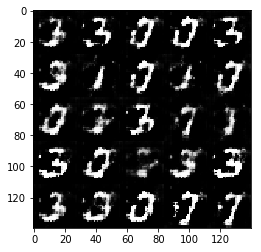

Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 3.4483
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 2.2814
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 0.2260... Generator Loss: 3.6295
Epoch 1/2... Discriminator Loss: 0.3422... Generator Loss: 3.0878
Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 2.9066
Epoch 1/2... Discriminator Loss: 0.1804... Generator Loss: 2.8526
Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 2.3792
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.3942
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 5.7482


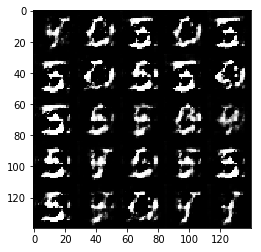

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 2.0175
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 1.7630
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 3.5885
Epoch 1/2... Discriminator Loss: 0.2573... Generator Loss: 2.5529
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 1.4498
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 2.4517
Epoch 1/2... Discriminator Loss: 0.4563... Generator Loss: 2.9478
Epoch 1/2... Discriminator Loss: 0.4438... Generator Loss: 1.6781
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.0090


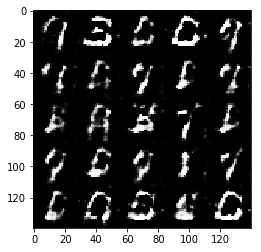

Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 3.6916
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 2.6689
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.8802
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 1.8670
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.6316
Epoch 1/2... Discriminator Loss: 0.2719... Generator Loss: 3.3132
Epoch 1/2... Discriminator Loss: 0.2143... Generator Loss: 2.9195
Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.4437
Epoch 1/2... Discriminator Loss: 0.2634... Generator Loss: 2.2645


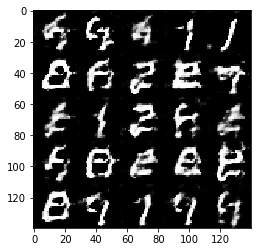

Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 4.0782
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.5098
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 2.5979
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.8238


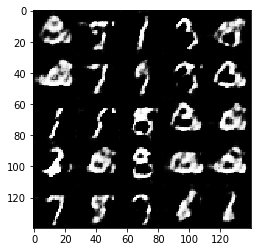

Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 2.4193
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 3.3455
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 1.6033
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.8332... Generator Loss: 4.8279
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 2.2603
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.1816
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.4708


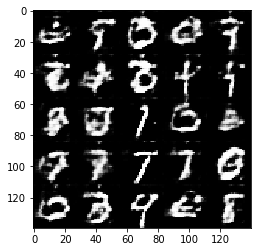

Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 2.9427
Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 1.3716
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.2198
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 1.5833... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 2.7619


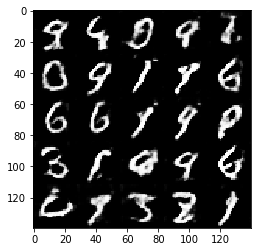

Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 1.5803
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 2.7889
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.5732
Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.2129
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 2.8908


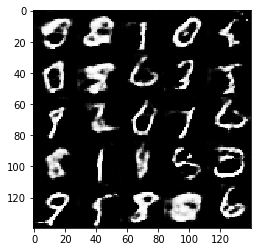

Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.2901
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.2508
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.4618
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.1372
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 2.0496... Generator Loss: 0.2043
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 0.3311


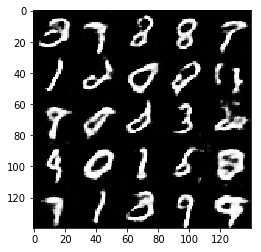

Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 1.8045
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.0519
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.3430
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5175


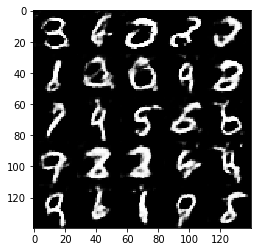

Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.2057... Generator Loss: 2.5926
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 1.4309
Epoch 1/2... Discriminator Loss: 0.6244... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.6557
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.6968... Generator Loss: 0.3588


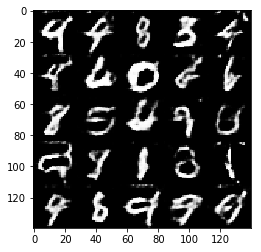

Epoch 1/2... Discriminator Loss: 0.9848... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.7923
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.4771
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 1.8398
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 2.9186
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 2.0476


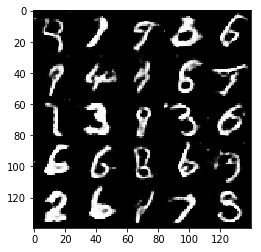

Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.5660... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 3.3140
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.6034


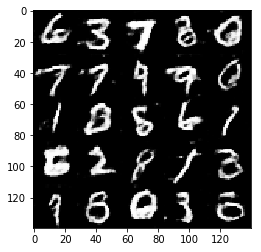

Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.7503... Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.5033
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 0.7697


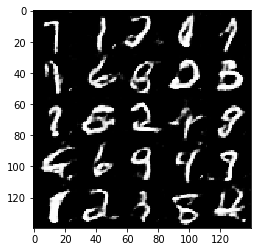

Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 0.9595
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.3929
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.6623
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.9160
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.6130


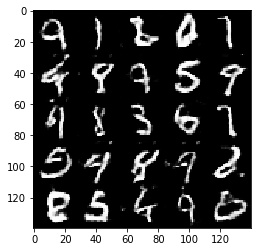

Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.5692
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 1.4259
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.5265
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.8132


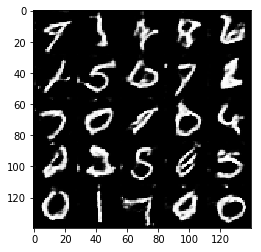

Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.2009
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.3814
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 1.8916
Epoch 2/2... Discriminator Loss: 1.4484... Generator Loss: 0.4024


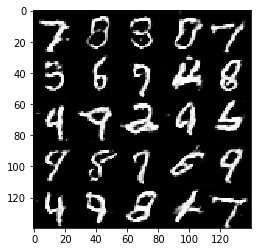

Epoch 2/2... Discriminator Loss: 1.7877... Generator Loss: 0.2541
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.8716
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 1.6386
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 1.7769
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.3992
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 1.0271


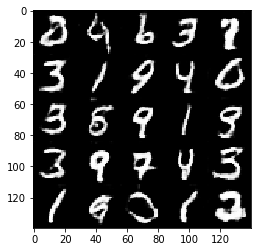

Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.4023


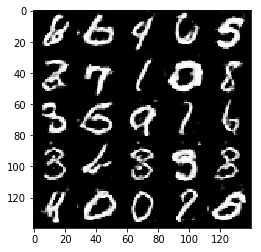

Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 0.3637
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.8111... Generator Loss: 0.2238
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.3546
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.3675
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 2.8905
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 2.6025


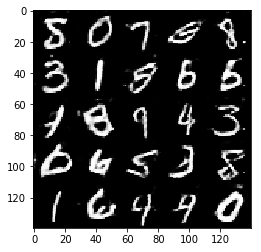

Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.7266
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.4083
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 2.0316... Generator Loss: 0.1992
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.7945


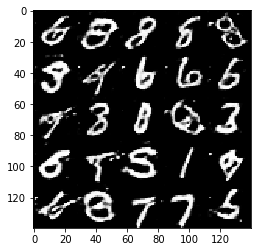

Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.5793
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 1.6685... Generator Loss: 0.3101
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.3718
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 1.2450


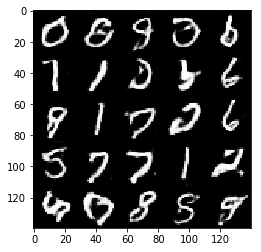

Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.3756
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.7074
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 0.6505


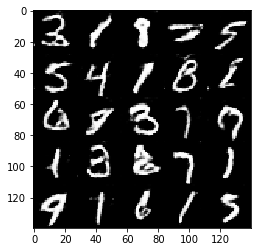

Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.3272
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.5313
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.1976
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 2.0717
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.4953... Generator Loss: 0.3620
Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 0.5727


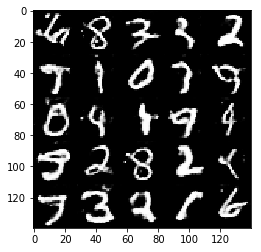

Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.5652
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 1.3611
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 2.2801... Generator Loss: 4.1793
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 0.9432
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 0.9251


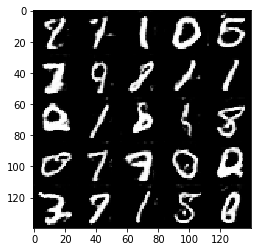

Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.0354
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.6053
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.6790


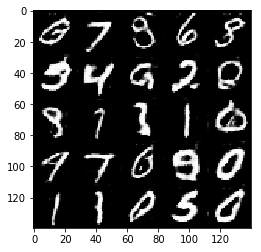

Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.4239
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.2628
Epoch 2/2... Discriminator Loss: 1.5694... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 0.6309


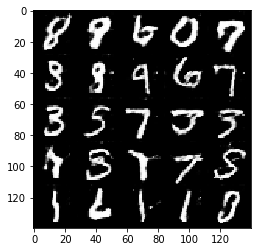

Epoch 2/2... Discriminator Loss: 2.3057... Generator Loss: 0.1882
Epoch 2/2... Discriminator Loss: 1.5269... Generator Loss: 0.3254
Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 2.0214... Generator Loss: 0.1991
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.8163... Generator Loss: 0.2821
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.4791


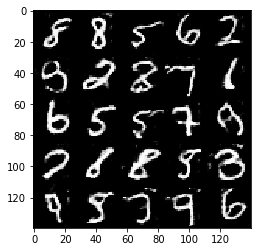

Epoch 2/2... Discriminator Loss: 1.5811... Generator Loss: 0.3129
Epoch 2/2... Discriminator Loss: 0.7977... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 2.4708
Epoch 2/2... Discriminator Loss: 1.8855... Generator Loss: 0.3397
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 3.1106
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 2.5154
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.6451... Generator Loss: 0.2783
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.6585


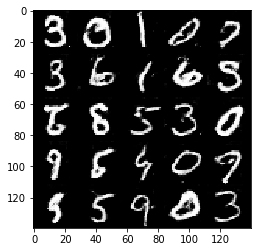

Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 2.2967
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 2.1726
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.3823
Epoch 2/2... Discriminator Loss: 1.9714... Generator Loss: 0.2056
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.0487
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.1074


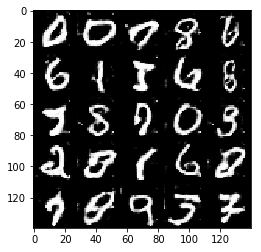

Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.8485
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 2.3344
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 1.2730
Epoch 2/2... Discriminator Loss: 1.7519... Generator Loss: 0.3926
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 0.6135... Generator Loss: 1.0491
Epoch 2/2... Discriminator Loss: 1.8243... Generator Loss: 0.2551


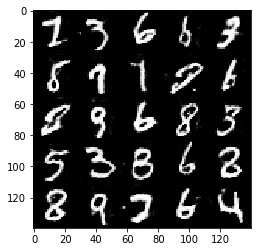

Epoch 2/2... Discriminator Loss: 2.0729... Generator Loss: 0.2234
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.4042
Epoch 2/2... Discriminator Loss: 1.8920... Generator Loss: 0.2361
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 1.2393


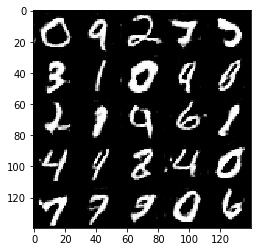

Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 2.6290
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.6987... Generator Loss: 0.3482
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.5378
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.5127


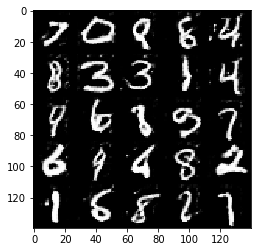

Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.7211
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 1.4486
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 0.9232


In [31]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 10.2116
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 6.7299
Epoch 1/1... Discriminator Loss: 3.6771... Generator Loss: 0.0303
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 11.3219
Epoch 1/1... Discriminator Loss: 0.3212... Generator Loss: 9.0577
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.3444


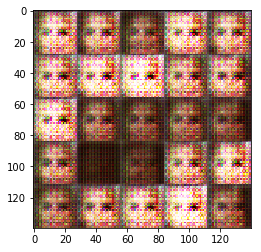

Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 5.4021
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.5189
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.7057
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5476


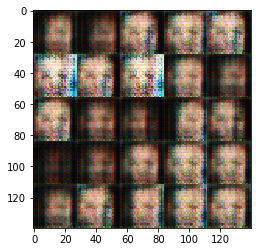

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 3.1756
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 2.8438
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 3.1463
Epoch 1/1... Discriminator Loss: 2.3035... Generator Loss: 2.1251
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 4.4207
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6266


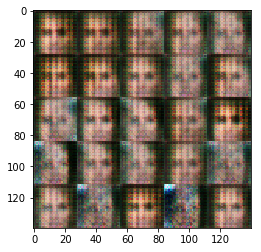

Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.6930
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.7584
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 3.0453
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0688


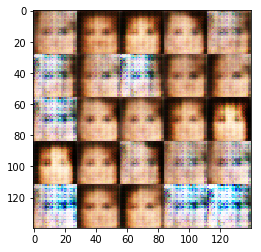

Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 2.4638
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.9259
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0993


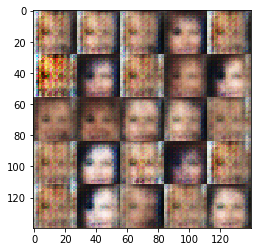

Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.8621
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 2.7808... Generator Loss: 5.8293


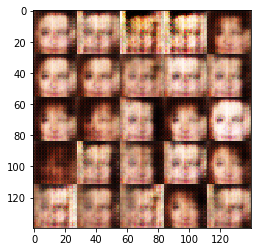

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 2.1065
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.2142


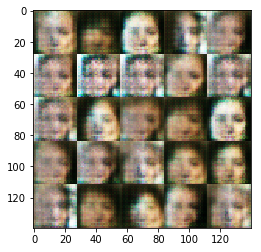

Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 2.9793
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.5037
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 2.0679


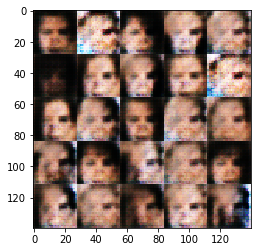

Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 4.5264
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.4771


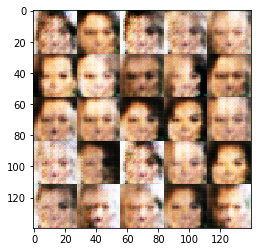

Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 3.7410
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 2.0007... Generator Loss: 4.7336
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.1943


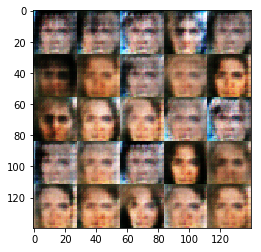

Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.0078


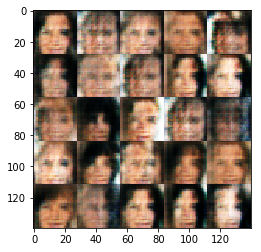

Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 2.7450
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.1972


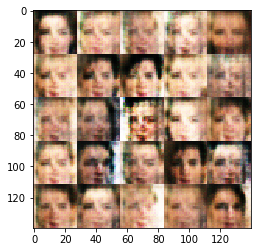

Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 3.1117
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 3.3216
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.4666


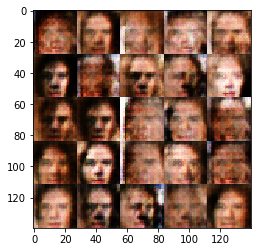

Epoch 1/1... Discriminator Loss: 2.0999... Generator Loss: 0.2231
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 2.1042
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 2.0199
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 2.0080
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 0.8708


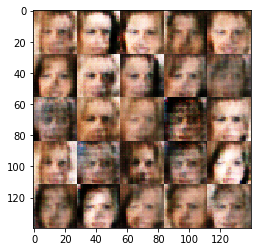

Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.8175
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.8134
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 3.0385


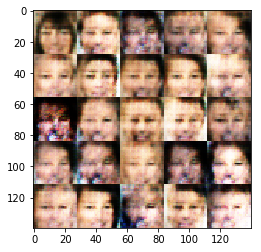

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 3.4477
Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.9050
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.0596


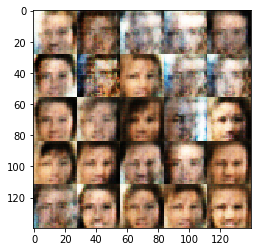

Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.2412


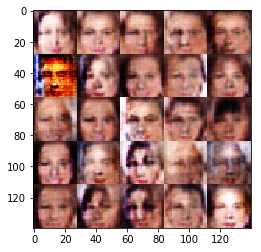

Epoch 1/1... Discriminator Loss: 1.7646... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.9616


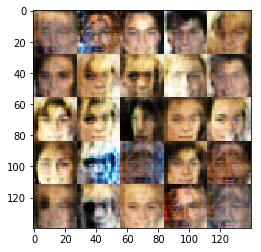

Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.3423


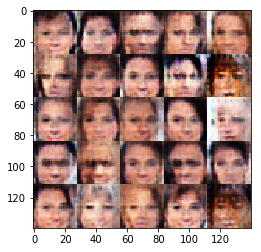

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.6334... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.4291


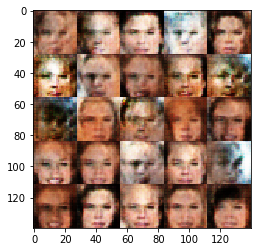

Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 1.9312... Generator Loss: 0.2573
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 2.2976
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7021


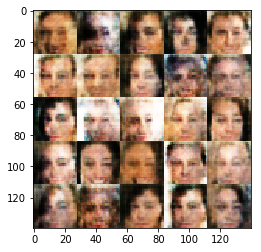

Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.9589
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.7168


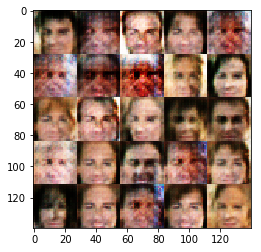

Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.7433
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.7512


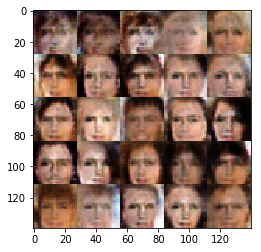

Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 2.1884
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.8637


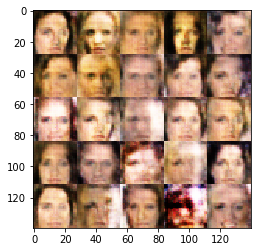

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8620


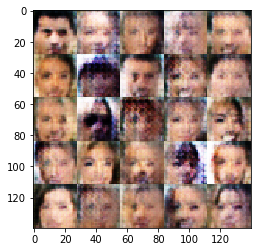

Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 2.3720
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 2.6640
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.2377
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9716


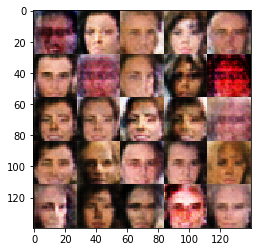

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.1167
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7536


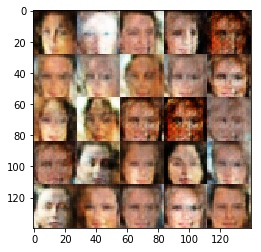

Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.8507... Generator Loss: 0.2459
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.5735
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.8629


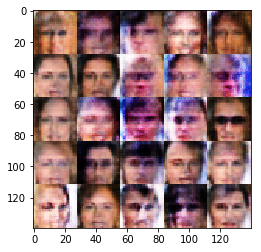

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.6794
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.2829


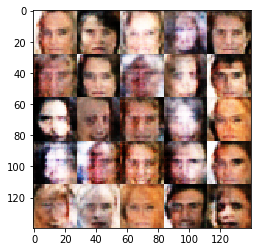

Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 2.0433
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.3957


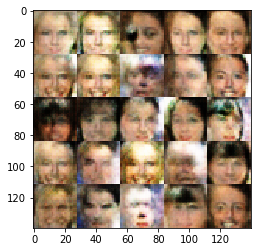

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.8665
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.9838


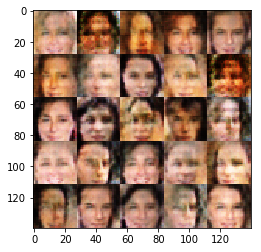

Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.6197


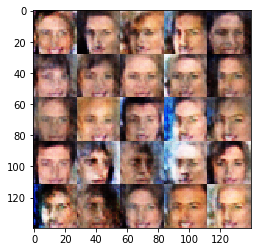

Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.3743


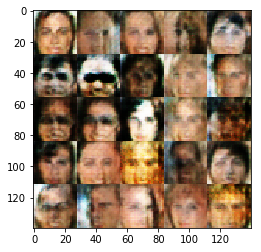

Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.2618


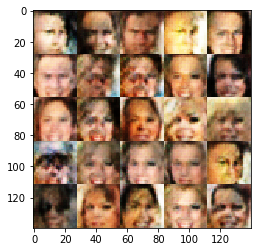

Epoch 1/1... Discriminator Loss: 1.9749... Generator Loss: 0.2541
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.4095


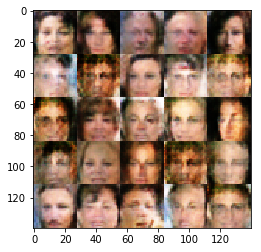

Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.2093


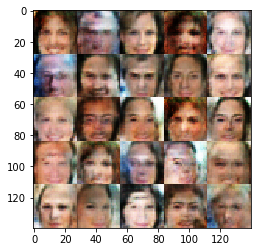

Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 2.2909


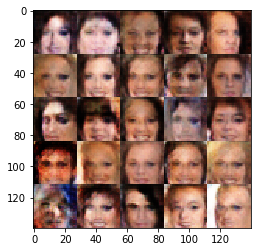

Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.4285
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.3994


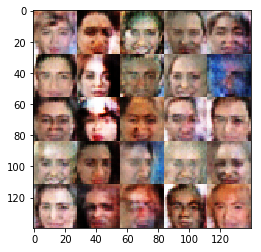

Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.8628


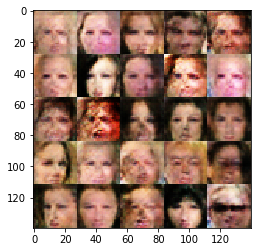

Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.3672


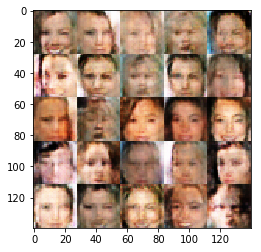

Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.8880


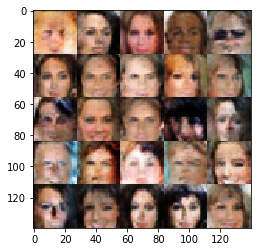

Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 2.0696
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.3924


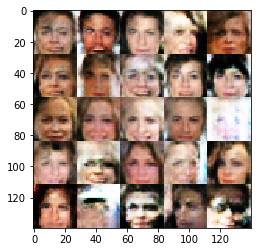

Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 2.3555
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.5019


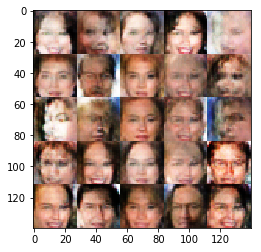

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.6977... Generator Loss: 1.0384


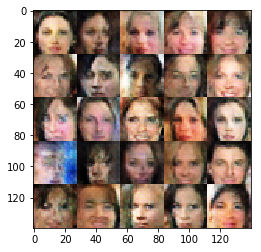

Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 1.8161... Generator Loss: 0.2588
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1372


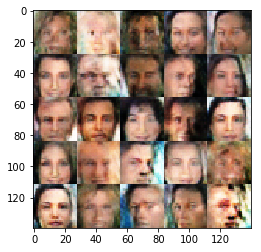

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 1.0506


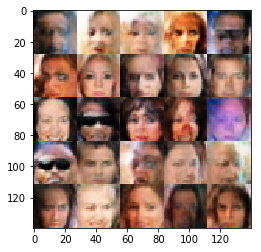

Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.9499
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9375


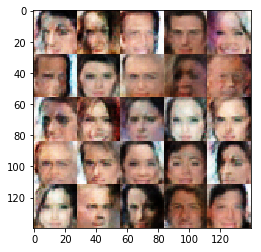

Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.2413


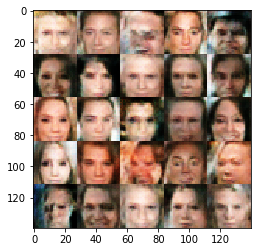

Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.7923
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8111


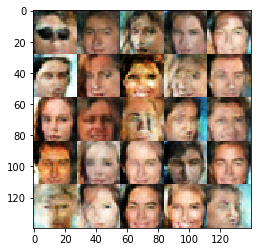

Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6274


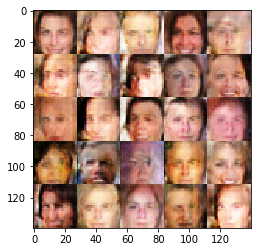

Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.8142


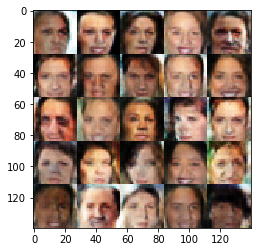

Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.6249


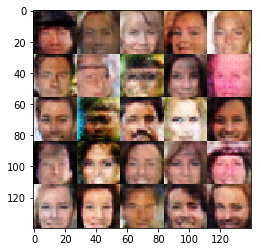

Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9527


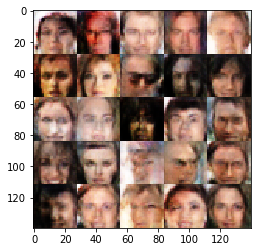

Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7488


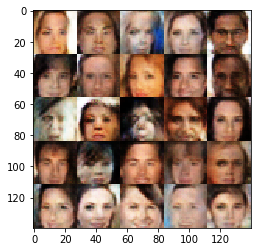

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.9721... Generator Loss: 0.2386
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.0390


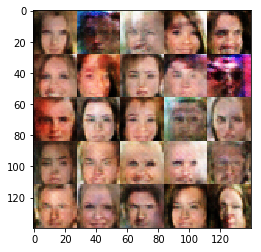

Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.9294


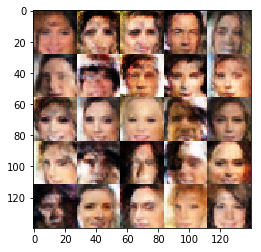

Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6996


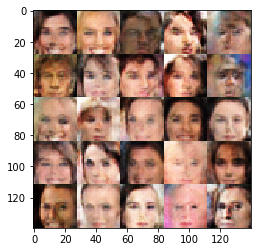

Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.0130


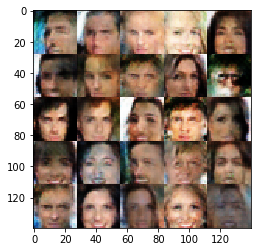

Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.4560


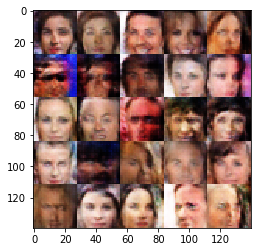

Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.9581


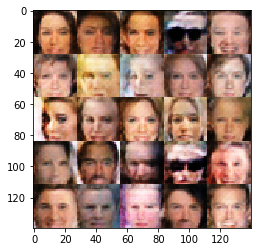

Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.7230... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.9989


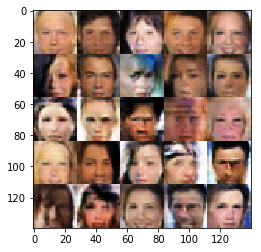

Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8162


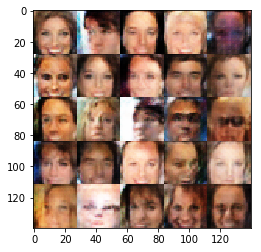

Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 1.3700


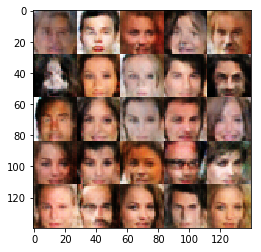

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.0036


In [32]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.